# GFS CA Sell-out

Goal: 
1. Process GFS CA data
2. Analyze data using COVID segmentation
3. Compare sell-out (GFS CA) to sell-in (McCain) data

### 1. Load libraries, initiate folder/file paths
Run cell below

In [1]:
import pandas as pd
import datetime
from datetime import datetime as dt
import numpy as np
import teradatasql
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
%matplotlib inline

#path where dictionary file can be found
#Neil
DICTIONARY = r'C:\Users\NEWATTER\OneDrive - McCain Foods Limited\Distributor Sell-Out Dictionaries\\'
#Joe
#DICTIONARY = r'C:\Users\jcronk\McCain Foods Limited\GNA Data Strategy & Analytics - COVID Recovery\Distributor Sell-Out Dictionaries\\'

#main path
#Neil
PATH = r'C:\Users\NEWATTER\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\\'
#Joe
#PATH = r'C:\Users\jcronk\McCain Foods Limited\GNA Data Strategy & Analytics - COVID Recovery\Historical Sell-Out Sales\\'

#backup path
#Neil
BACKUP = r'C:\Users\NEWATTER\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\Backups\\'
#Joe
#BACKUP = r'C:\Users\jcronk\McCain Foods Limited\GNA Data Strategy & Analytics - COVID Recovery\Historical Sell-Out Sales\Backups\\'

#time dataframe
TIME = pd.read_excel(DICTIONARY + 'Time Definitions.xlsx')

### 2. Data Dictionary
Run cell below

In [2]:
def apply_dictionary(df, file_name):
    
    #create dictionary object from Excel file
    #adding sheet_name = None makes it a dictionary type
    _dict = pd.read_excel(DICTIONARY + file_name, sheet_name = None)

    #create DataFrame from dictionary object called dict (short for dictionary)
    dict_df = pd.DataFrame.from_dict(_dict['Segment Mapping'])
    
    #create DataFrame from dictionary object called cat (short for category)
    cat_df = pd.DataFrame.from_dict(_dict['Province Mapping'])
    cat_df = cat_df[['Province','Cleaned Province Name','Geographic Region']]
    
    #print shape of df (dimensions)
    print(f'Shape before adding dictionary: {df.shape}', flush = True)
    
    #testing total lbs to see if it matches after merge
    total_lbs = df['Total Lbs'].sum()
    print(f'Total before dictionary: {total_lbs}', flush = True)
    
    #add lower case for merging
    dict_df['Segment-lower'] = dict_df['Segment'].str.lower()
    dict_df['Sector-lower'] = dict_df['Sector'].str.lower()
    dict_df['Sub-segment-lower'] = dict_df['Sub Segment'].str.lower()
    
    #fill all blanks with text 'blank' 
    dict_df = dict_df.groupby(['McCain COVID/MWOW Segmentation','COVID Segmentation - L2','COVID Segmentation - (Restaurants)','Restaurant Service Type',
                               'Sector-lower','Segment-lower','Sub-segment-lower'], dropna = False).size().reset_index().drop(columns={0})
    
    #!!!-Update base data-!!!#
    #new rule 12/9/2020: Sector MEU-IO -> MEU
    #updated 2/25/2021: MEU0IO -> MEU
    df.loc[(df['Sector'] == 'MEU-IO') | (df['Sector'] == 'MEU0IO'),'Sector'] = 'MEU'
    df.loc[(df['Sector'] == 'MEU - IO') | (df['Sector'] == 'MEU0IO'),'Sector'] = 'MEU'
    df.loc[(df['Sector'] == 'MEU - Unit') | (df['Sector'] == 'MEU0IO'),'Sector'] = 'MEU'
    
    #add lower case key columns for merging (removes case mismatch)
    df['Sector-lower'] = df['Sector'].str.lower()
    df['Segment-lower'] = df['Segment'].str.lower()
    df['Sub-segment-lower'] = df['Sub Segment'].str.lower()
    
    #remove lower case key columns
    df = df.merge(dict_df, how = 'left', left_on = ['Sector-lower', 'Segment-lower', 'Sub-segment-lower'], 
                  right_on = ['Sector-lower', 'Segment-lower', 'Sub-segment-lower']).drop(columns = {'Sector-lower','Segment-lower','Sub-segment-lower'})
    
    
    print(df['McCain COVID/MWOW Segmentation'].value_counts())
    
    #add Clean Province Name
    df = df.merge(cat_df, how = 'left', left_on = ['Province'], right_on = ['Province'])
    
    #clean up 0's in Province Name, this creates errors with Teradata queries
    df.loc[(df['Cleaned Province Name'] == 0) | (df['Cleaned Province Name'].isna()), 'Cleaned Province Name'] = 'Other'
    
    #clean city names
    df = clean_city(df)
    
    df['Fiscal Week (GFS)'] = df['Fiscal Year'].astype(str) + df['Fiscal Week'].astype(str).str.zfill(2)
    df['Fiscal Week (GFS)'] = df['Fiscal Week (GFS)'].astype('int64')
    
     #apply calendar week
    df = df.merge(TIME[['Fiscal Week (GFS)', 'Calendar Week Year']], how = 'left', on = ['Fiscal Week (GFS)']).drop(columns = {'Fiscal Week (GFS)'})
    
    df = df.rename(columns = {'Total Lbs':'LBS',
                              'Product Category':'Consolidated Category'})
    
    if 'Consolidated Category' in df.columns:
        df.loc[df['Consolidated Category'].str.match('Potato'), 'Consolidated Category'] = 'Potato'
        df.loc[~df['Consolidated Category'].str.match('Potato'), 'Consolidated Category'] = 'Prepared Foods'
    else:
        df.loc[df['Simple Product Category'] == 'Potato', 'Consolidated Category'] = 'Potato'
        df.loc[df['Simple Product Category'] == 'Non-Potato', 'Consolidated Category'] = 'Prepared Foods'
        
    #testing total lbs to see if it matches after merge
    total_lbs = df['LBS'].sum()
    print(f'Total after dictionary: {total_lbs}', flush = True)

    #print final shape to see if anything changes (would indicate duplicates in dictionary)
    print(f'Shape after adding dictionary: {df.shape}', flush = True)
    
    return df

### 3. Import File
Run cell below

In [3]:
def import_file(file_name):
    
    if '.csv' in file_name:
        _import = pd.read_csv(file_name, low_memory = False, thousands = ',', encoding='cp1252')
    else:
        _import = pd.read_excel(file_name)
    
    return _import

### 4. Calculation Functions
Run cell below

In [4]:
def add_rolling(df, _list):
    #groupby _list
    df = df.groupby(_list, dropna = False)[['LBS','LBS_LY','LBS_Baseline']].sum().reset_index()
    
    #set index to all but last column in list
    df = df.set_index(_list)
    
    #add new metric SMA_4 (simple moving average - 4 periods)
    #level = all but last 2 items in list
    df['LBS_Lag_1'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 1)
    df['LBS_Lag_2'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 2)
    df['LBS_Lag_3'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 3)
    df['LBS_Lag_4'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 4)
    
    df['SMA_4'] = df.groupby(level=_list[0:-1])['LBS'].apply(lambda x: x.rolling(4, min_periods=1).mean())
    df['SMA_8'] = df.groupby(level=_list[0:-1])['LBS'].apply(lambda x: x.rolling(8, min_periods=1).mean())
    df['SMA_12'] = df.groupby(level=_list[0:-1])['LBS'].apply(lambda x: x.rolling(12, min_periods=1).mean())
    
    df['SMA_4_LY'] = df.groupby(level=_list[0:-1])['LBS_LY'].apply(lambda x: x.rolling(4, min_periods=1).mean())
    df['SMA_8_LY'] = df.groupby(level=_list[0:-1])['LBS_LY'].apply(lambda x: x.rolling(8, min_periods=1).mean())
    df['SMA_12_LY'] = df.groupby(level=_list[0:-1])['LBS_LY'].apply(lambda x: x.rolling(12, min_periods=1).mean())
    
    df['SMA_4_Baseline'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].apply(lambda x: x.rolling(4, min_periods=1).mean())
    df['SMA_8_Baseline'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].apply(lambda x: x.rolling(8, min_periods=1).mean())
    df['SMA_12_Baseline'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].apply(lambda x: x.rolling(12, min_periods=1).mean())
    
    df['LBS_Baseline_Lag_1'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].shift(periods = 1)
    df['LBS_LY_Lag_1'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 1)
    
    df['SMA_4_Lag_1'] = df.groupby(level=_list[0:-1])['SMA_4'].shift(periods = 1)
    df['SMA_4_LY_Lag_1'] = df.groupby(level=_list[0:-1])['SMA_4_LY'].shift(periods = 1)
    df['SMA_4_Baseline_Lag_1'] = df.groupby(level=_list[0:-1])['SMA_4_Baseline'].shift(periods = 1)
    
    return df.reset_index()


def add_last_year(df, _list):
    #list of groupby columns
    #last item in list is Calendar Week Year which is used to pull previous history (Baseline Week = Calendar Week Year) of copied dataframe
    _groupby = _list.copy()
    
    _merge_yoy = _list.copy()[0:-1]
    _merge_yoy.extend(['YOY Week'])
    
    _merge_baseline = _list.copy()[0:-1]
    _merge_baseline.extend(['Baseline Week'])
    
    df1 = df.groupby(_list, dropna = False)['LBS'].sum().reset_index()
    
    #groupby _list
    df_new = df.groupby(_list, dropna = False)['LBS'].sum().reset_index()
    
    #add week dimensions to main dataframe
    df_new = df_new.merge(TIME[['Calendar Week Year','YOY Week','Baseline Week']], how = 'left', left_on = 'Calendar Week Year', right_on = 'Calendar Week Year')
    
    df_new = df_new.merge(df1, how='left', left_on=_merge_yoy, right_on=_groupby).drop(columns={'Calendar Week Year_y'}).rename(columns={'LBS_y':'LBS_LY'})
    
    df_new = df_new.merge(df1, how='left', left_on=_merge_baseline, right_on=_groupby).drop(columns={'Calendar Week Year'}).rename(columns={
        'LBS':'LBS_Baseline','Calendar Week Year_x':'Calendar Week Year','LBS_x':'LBS'})
    
    return df_new


def add_precovid(df, _list, begin, end):
    #datefield should be last in _list
    datefield = _list[-1]
          
    #remove datefield from list
    _list = _list[0:-1]
    
    #filter data not using last and rename columns
    _df = df[(df[datefield] >= begin) & (df[datefield] <= end)].groupby(_list)['LBS'].sum() / 52
    
    return df.merge(
        _df, how = 'left', left_on = _list, right_on = _list).rename(
        columns = {'LBS_x':'LBS', 'LBS_y':'LBS_PRECOVID'}).fillna(
        value = {'LBS_PRECOVID': 0})


def add_time(df):
    df = df.merge(TIME[['Calendar Week Year','Week Starting (Sun)','Week Ending (Sat)', 'COVID Week']],
                   how = 'left', 
                   on = 'Calendar Week Year')
    
    df = df.merge(TIME[['Calendar Week Year','YOY Week','Baseline Week']], how = 'left', left_on = 'Calendar Week Year', right_on = 'Calendar Week Year')
    
    return df


def analyze_1(df, _list, begin, end):
    if 'Calendar Week Year' not in _list:
        _list.extend(['Calendar Week Year'])
    
    df = full_dataframe(df, _list)
    
    #add last year lbs
    df = add_last_year(df, _list)
    
    #add rolling calculation
    df = add_rolling(df, _list)
        
    #add preCOVID baseline
    df = add_precovid(df, _list, begin, end)
    
    df = df.round({
        'LBS' : 2,    
        'SMA_4' : 2,
        'SMA_8' : 2,
        'SMA_12' : 2,
        'LBS_LY' : 2,    
        'SMA_4_LY' : 2,
        'SMA_8_LY' : 2,
        'SMA_12_LY' : 2,
        'LBS_Baseline' : 2,    
        'SMA_4_Baseline' : 2,
        'SMA_8_Baseline' : 2,
        'SMA_12_Baseline' : 2,
        'LBS_PRECOVID' : 2,
        'LBS_Lag_1' : 2,
        'LBS_Lag_2' : 2,
        'LBS_Lag_3' : 2,
        'LBS_Lag_4' : 2,
        'LBS_Baseline_Lag_1': 2,
        'LBS_LY_Lag_1': 2,
        'SMA_4_Lag_1' : 2,
        'SMA_4_LY_Lag_1' : 2,
        'SMA_4_Baseline_Lag_1' : 2
        
    }).fillna(value = {
        'LBS' : 0,    
        'SMA_4' : 0,
        'SMA_8' : 0,
        'SMA_12' : 0,
        'LBS_LY' : 0,    
        'SMA_4_LY' : 0,
        'SMA_8_LY' : 0,
        'SMA_12_LY' : 0,
        'LBS_Baseline' : 0,    
        'SMA_4_Baseline' : 0,
        'SMA_8_Baseline' : 0,
        'SMA_12_Baseline' : 0,
        'LBS_PRECOVID' : 0,
        'LBS_Lag_1' : 0,
        'LBS_Lag_2' : 0,
        'LBS_Lag_3' : 0,
        'LBS_Lag_4' : 0,
        'LBS_Baseline_Lag_1': 2,
        'LBS_LY_Lag_1': 2,
        'SMA_4_Lag_1' : 0,
        'SMA_4_LY_Lag_1' : 0,
        'SMA_4_Baseline_Lag_1' : 0
        
    })
    
    return df


def save_backup(df, file_name):
    
    df.to_csv(BACKUP + file_name)
    
    return


def td_to_pandas(query, cur, title=''):
    _data = []
    _start=dt.now()
    print(dt.now().strftime('%m/%d/%Y'))
    print(f'{title} Execution started...', end='', flush=True)
    cur.execute (query)
    print(f'finished. {dt.now() - _start}', flush=True) 
    _start_fetch=dt.now()
    print(f'{title} Fetching data started...', end='', flush=True)
    for row in cur.fetchall():
        _data.append(row) 
    print(f'finished. {dt.now() - _start_fetch}', flush=True) 
    _start=dt.now()
    print(f'{title} Creating DataFrame for started...', end='', flush=True)
    _df = pd.DataFrame(_data)
    _df.columns = [x[0].replace('SAP_', '').lower() for x in cur.description]
    print(f'finished. {dt.now() - _start}', flush=True)
    return _df


def td_dataframe(select_db, query):
    with teradatasql.connect(None, 
                         host='172.29.3.43',
                         user='PNWATTERS',
                         password='teradata123') as con:
        with con.cursor() as cur:
            cur.execute (select_db)
            print('Database selected!', flush=True)            
            dim_df = td_to_pandas(query, cur, 'Query:')
            print('Dim:', dim_df.shape)
    
    return dim_df


def restaurants(df):
    
    #Rename rows
    df.loc[df['COVID Segmentation - L2'] == 'Independents (IOs) / Local Eateries / Takeaway', 'COVID Segmentation - L2'] = 'IO'
    df.loc[
        (df['COVID Segmentation - L2'] == 'All Other') | 
        (df['COVID Segmentation - L2'] == 'National Account') | 
        (df['COVID Segmentation - L2'] == 'Region Chains')| 
        (df['COVID Segmentation - L2'] == 'National Accounts'),
        'COVID Segmentation - L2'] = 'Chain'
    
    return df

def process_list(df, work_list):
    
    _process = analyze_1(df, work_list, 201910, 202009)
    
    _process = restaurants(_process)
    
    _process['Distributor'] = 'GFS CA'
    
    _process = add_time(_process)
    
    #for standardizing output
    work_list.extend(['Distributor','LBS','SMA_4','SMA_8','SMA_12',
                      'YOY Week','LBS_LY','SMA_4_LY','SMA_8_LY','SMA_12_LY',
                      'Baseline Week','LBS_Baseline','SMA_4_Baseline','SMA_8_Baseline','SMA_12_Baseline',
                      'LBS_Lag_1','LBS_Lag_2','LBS_Lag_3','LBS_Lag_4','LBS_Baseline_Lag_1','LBS_LY_Lag_1',
                      'SMA_4_Lag_1', 'SMA_4_LY_Lag_1', 'SMA_4_Baseline_Lag_1',
                      'LBS_PRECOVID','Week Starting (Sun)','Week Ending (Sat)','COVID Week'])
    
    return _process[work_list]

def full_dataframe(df, _list):
    weeks = df.groupby(['Calendar Week Year']).size().reset_index().drop(columns={0})
    segments = df.groupby(_list[0:-1]).size().reset_index().drop(columns={0})
    
    _df = segments.assign(key=1).merge(weeks.assign(key=1), how='outer', on='key').drop(columns = {'key'}) 
    
    return _df.merge(df, how = 'left', on = _list)

def clean_city(df):
    if 'City' in df.columns:
        #additional transformations
        df['City'] = df['City'].str.strip()
        df['City'] = df['City'].str.upper()
        df['City'].fillna('NA', inplace = True)

        cities = 'TORONTO|MONTREAL|OTTAWA|CALGARY|VANCOUVER|WINNIPEG|MONTREAL|HAMILTON|HALIFAX'

        #change each city name to the name of the city that matches, cleans up the city names
        for c in cities.split('|'):
            df.loc[df['City'].str.match(c), 'City'] = c

        #change all other cities to NA
        df.loc[~df['City'].str.match(cities), 'City'] = 'NA'
    else:
        df['City'] = 'NA'
        
    return df

### 5. Sell-in vs. Sell-out
Run cell below

In [5]:
def teradata_sales(sellout):
    #SET QUERY_BAND = 'ApplicationName=MicroStrategy;Version=9.0;ClientUser=NEWATTER;Source=Vantage; Action=BEK Performance;StartTime=20200901T101924;JobID=55096;Importance=666;'  FOR SESSION;
    
    #the current week is pulled from the time dictionary table
    to_week = int(TIME[(TIME['Week Starting (Mon)'] <= dt.now()) & (TIME['Week Ending (Sun)'] >= dt.now())]['Calendar Week Year'].values)
    
    print(f'Starting Teradata connect...', flush = True)
    
    select_db = "DATABASE DL_GBL_TAS_BI"

    query = '''
    select a14.FISCAL_WEEK_NUMBER as FISCAL_WEEK_NUMBER,
    (a14.FISCAL_WEEK_NUMBER_DESCR || ' ' || a14.START_DATE_OF_SAPYW) as FISCAL_WEEK,
    a14.CALENDAR_WEEK_NAME as CALENDAR_WEEK_NUMBER,
    (a14.CALENDAR_WEEK_LONG_DESCRIPTION || ' ' || a14.START_DATE_OF_SAPYW) as CALENDAR_WEEK,
    RIGHT(a15.CUSTOMER_HIER_LVL_1,CAST(10 AS INTEGER)) as CUSTOMER_HIER_LVL_1,
    a15.CUSTOMER_HIER_LVL_1_NAME as CUSTOMER_HIER_LVL_1_NAME,
    a11.CUSTOMER_ID as CUSTOMER_ID,
    a17.CUSTOMER_NAME as CUSTOMER_NAME,
    a12.CATEGORY_SHORT_CODE as CATEGORY_SHORT_CODE,
    a12.CATEGORY_DESC as CATEGORY_DESC,
    a13.DIVISION_ID as DIVISION,
    a16.DIVISION_NAME as DIVISION_NAME,
    TRIM (LEADING '0' FROM a13.MATERIAL_ID) as MATERIAL_ID,
    a13.MATERIAL_DESCRIPTION as MATERIAL_NAME,
    sum(a11.SALES_VOLUME_WEIGHT_LBS) as ACTUAL_VOLUME_LBS
    from DL_GBL_TAS_BI.FACT_SALES_ACTUAL as a11
    join DL_GBL_TAS_BI.VW_H_PRODUCT_ALL_SALES as a12
     on (a11.MATERIAL_ID = a12.MATERIAL_ID)
    join DL_GBL_TAS_BI.D_MATERIAL_DN_ALL as a13
     on (a11.MATERIAL_ID = a13.MATERIAL_ID)
    join DL_GBL_TAS_BI.D_TIME_FY_V6 as a14
     on (a11.ACCOUNTING_PERIOD_DATE = a14.DAY_CALENDAR_DATE)
    join DL_GBL_TAS_BI.VW_H_CUSTOMER_ALL_DIVISION00 as a15
     on (a11.CUSTOMER_ID = a15.CUSTOMER and 
    a11.DISTRIBUTION_CHANNEL_ID = a15.DISTRIBUTION_CHANNEL and 
    a11.SALES_ORGANISATION_ID = a15.SALES_ORGANISATION)
    join DL_GBL_TAS_BI.D_DIVISION as a16
     on (a13.DIVISION_ID = a16.DIVISION_ID)
    join DL_GBL_TAS_BI.D_CUSTOMER as a17
     on (a11.CUSTOMER_ID = a17.CUSTOMER_ID)
    where (a11.SALES_ORGANISATION_ID in ('CA01')
     and a11.DISTRIBUTION_CHANNEL_ID in ('10')
     and RIGHT(a15.CUSTOMER_HIER_LVL_1,CAST(10 AS INTEGER)) in ('6500002783', '6500002891', '6500002893'))
     and a11.CUSTOMER_ID not in ('1000086317','1000086323','1000086325','1000086324','1001215033','1000076119','1000086304','1000086306','1000086305','1000086301','1000086300','1001222492','1001221774')
     and a12.BRAND_DESC not in ('Tim Hortons','M&M')
     and a14.CALENDAR_WEEK_NAME between 201901 and ''' + str(to_week - 1) + '''
    group by a14.FISCAL_WEEK_NUMBER,
    (a14.FISCAL_WEEK_NUMBER_DESCR || ' ' || a14.START_DATE_OF_SAPYW),
    a14.CALENDAR_WEEK_NAME,
    (a14.CALENDAR_WEEK_LONG_DESCRIPTION || ' ' || a14.START_DATE_OF_SAPYW),
    RIGHT(a15.CUSTOMER_HIER_LVL_1,CAST(10 AS INTEGER)),
    a15.CUSTOMER_HIER_LVL_1_NAME,
    a11.CUSTOMER_ID,
    a17.CUSTOMER_NAME,
    a12.CATEGORY_SHORT_CODE,
    a12.CATEGORY_DESC,
    a13.DIVISION_ID,
    a16.DIVISION_NAME,
    TRIM (LEADING '0' FROM a13.MATERIAL_ID),
    a13.MATERIAL_DESCRIPTION
    ;'''

    #create dataframe using both functions td_to_pandas and td_dataframe
    df = td_dataframe(select_db, query)
    
    return teradata_transform(df, sellout)


def teradata_transform(sellin, sellout):
    #consolidates teradata sales with sellout data
    
    #convert from object datatype to float (exports as a number instead of string)
    sellin['actual_volume_lbs'] = sellin['actual_volume_lbs'].astype('float64')
    
    #rename columns for consistancy
    sellin = sellin.rename(columns = {'actual_volume_lbs':'LBS', 'calendar_week_number':'Calendar Week Year'})
    
    #transform calendar week year from teradata
    sellin['Calendar Week Year'] = pd.to_numeric(sellin['Calendar Week Year'], errors = 'coerce')

    #transform category so its consolidated
    sellin['Consolidated Category'] = sellin['category_desc']
    sellin.loc[sellin['Consolidated Category'] == 'Sweet Potato' , 'Consolidated Category'] = 'Potato'
    sellin.loc[sellin['Consolidated Category'] != 'Potato' , 'Consolidated Category'] = 'Prepared Foods'
    
    #analyze sellin data
    sellin = analyze_1(sellin, ['Consolidated Category'], 201910, 202009)
    
    #rename columns accordingly
    sellin = sellin.rename(columns = {'LBS':'MCCAIN LBS',
                                      'SMA_4':'MCCAIN SMA_4',
                                      'SMA_8':'MCCAIN SMA_8',
                                      'SMA_12':'MCCAIN SMA_12',
                                      'LBS_PRECOVID':'MCCAIN PRECOVID',
                                      'LBS_Lag_1':'MCCAIN Lag_1',
                                      'LBS_Lag_2':'MCCAIN Lag_2',
                                      'LBS_Lag_3':'MCCAIN Lag_3',
                                      'LBS_Lag_4':'MCCAIN Lag_4',
                                      'LBS_Baseline' : 'MCCAIN LBS_Baseline',
                                      'SMA_4_Baseline' : 'MCCAIN SMA_4_Baseline',
                                      'SMA_8_Baseline' : 'MCCAIN SMA_8_Baseline',
                                      'SMA_12_Baseline' : 'MCCAIN SMA_12_Baseline',
                                      'SMA_4_Lag_1':'MCCAIN SMA_4_Lag_1',
                                      'SMA_4_Baseline_Lag_1' : 'MCCAIN SMA_4_Baseline_Lag_1',
                                      'LBS_Baseline_Lag_1': 'MCCAIN LBS_Baseline_Lag_1'
                                     })
    
    #analyze sellout data
    df = analyze_1(sellout, ['Consolidated Category'], 201910, 202009)
                                    
    df = df.merge(sellin[['Calendar Week Year','Consolidated Category','MCCAIN LBS','MCCAIN SMA_4','MCCAIN SMA_8','MCCAIN SMA_12','MCCAIN PRECOVID',
                          'MCCAIN LBS_Baseline','MCCAIN SMA_4_Baseline','MCCAIN SMA_8_Baseline','MCCAIN SMA_12_Baseline',
                          'MCCAIN Lag_1', 'MCCAIN Lag_2', 'MCCAIN Lag_3', 'MCCAIN Lag_4','MCCAIN LBS_Baseline_Lag_1',
                          'MCCAIN SMA_4_Lag_1', 'MCCAIN SMA_4_Baseline_Lag_1']], how = 'left', 
                  left_on = ['Calendar Week Year','Consolidated Category'], right_on = ['Calendar Week Year','Consolidated Category'])
    
    df = df.fillna({'MCCAIN LBS': 0,
                    'MCCAIN SMA_4': 0,
                    'MCCAIN SMA_8': 0,
                    'MCCAIN SMA_12': 0,
                    'MCCAIN PRECOVID': 0,
                    'MCCAIN Lag_1': 0,
                    'MCCAIN Lag_2': 0,
                    'MCCAIN Lag_3': 0,
                    'MCCAIN Lag_4': 0,
                    'MCCAIN LBS_Baseline': 0,
                    'MCCAIN SMA_4_Baseline': 0,
                    'MCCAIN SMA_8_Baseline': 0,
                    'MCCAIN SMA_12_Baseline': 0,
                    'MCCAIN LBS_Baseline_Lag_1':0,
                    'MCCAIN SMA_4_Lag_1' : 0,
                    'MCCAIN SMA_4_Baseline_Lag_1' : 0
                   })
    
    df['Distributor'] = 'GFS CA'

    df = add_time(df)
    
    df = df[['Consolidated Category','Distributor','Calendar Week Year',
             'LBS','SMA_4','SMA_8','SMA_12','LBS_PRECOVID',
             'LBS_Baseline','SMA_4_Baseline','SMA_8_Baseline','SMA_12_Baseline',
             'LBS_Lag_1', 'LBS_Lag_2', 'LBS_Lag_3', 'LBS_Lag_4', 'LBS_Baseline_Lag_1', 'SMA_4_Lag_1', 'SMA_4_Baseline_Lag_1',
             'MCCAIN LBS','MCCAIN SMA_4','MCCAIN SMA_8','MCCAIN SMA_12','MCCAIN PRECOVID',
             'MCCAIN LBS_Baseline','MCCAIN SMA_4_Baseline','MCCAIN SMA_8_Baseline','MCCAIN SMA_12_Baseline',
             'MCCAIN Lag_1', 'MCCAIN Lag_2', 'MCCAIN Lag_3', 'MCCAIN Lag_4','MCCAIN LBS_Baseline_Lag_1','MCCAIN SMA_4_Lag_1','MCCAIN SMA_4_Baseline_Lag_1',
             'Week Starting (Sun)','Week Ending (Sat)','COVID Week']]
    
    return df

### 6. Import Raw Data
Run cell below

In [6]:
'''
RangeIndex: 721557 entries, 0 to 721556
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   SumOfCases                  721557 non-null  int64         
 1   Total Lbs                   721557 non-null  float64       
 2   Segment                     718207 non-null  object        
 3   Sub Segment                 696409 non-null  object        
 4   Sector                      721557 non-null  object        
 5   Distributor Classification  721554 non-null  object        
 6   Product Category            721557 non-null  object        
 7   Division                    721557 non-null  object        
 8   Province                    721557 non-null  object        
 9   Fiscal Year                 721557 non-null  int64         
 10  Fiscal Week                 721557 non-null  int64         
 11  Start Date                  721557 non-null  datetime64[ns]
 12  End Date                    721557 non-null  datetime64[ns]
 13  City                        719905 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(8)
memory usage: 77.1+ MB
'''

#create main dataframe from base file
_import = import_file(PATH + 'GFS CA Weekly Update.xlsx')

print(f'Imported {_import.shape[0]} records', flush = True)

Imported 957770 records


In [7]:
print(_import['Simple Product Category'].value_counts())

Potato        588204
Non-Potato    319740
Name: Simple Product Category, dtype: int64


### Graph latest results

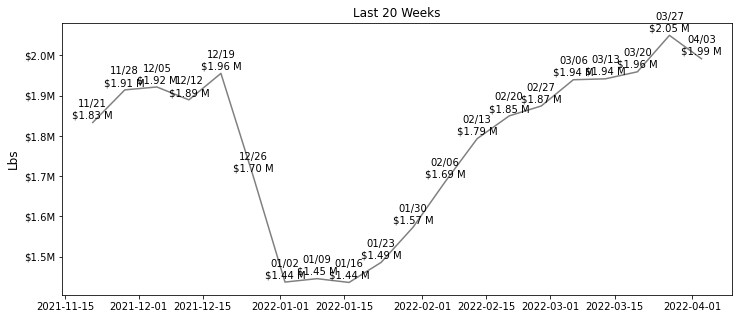

In [7]:


weekly = _import.groupby(pd.Grouper(key="End Date", freq="1W"))['Total Lbs'].sum().reset_index().tail(20).set_index('End Date')

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1 = sns.lineplot(x='End Date', y='Total Lbs', data=weekly, color='gray')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,.1f}'.format(x/1000000) + 'M'))
ax1.set_title('Last 20 Weeks',size=12)
ax1.set_ylabel('Lbs',size=12)
ax1.set_xlabel(None)

for index, row in weekly.iterrows():
    #print(index)
    #print(ax1.patches[index].get_height())
    #print(row.customer_name2)
    #print(row['Total Lbs'])
    ax1.text(index, row['Total Lbs']+10000, datetime.datetime.strftime(index, "%m/%d") + "\n${:,.2f} M".format(row['Total Lbs']/1000000), color='black', ha="center", size=10)
    

### 7. Apply Dictionary to Raw Data
Run cell below

In [8]:
#add dictionary to base data
_base = apply_dictionary(_import, 'GFS - CA.xlsx').dropna(subset={'Calendar Week Year'}).astype({'Calendar Week Year':'int64'})

#_restaurants = restaurants(_base)

Shape before adding dictionary: (957770, 14)
Total before dictionary: 309229727.9200001
Casual Dining                     380218
QSR / Fast Casual                 236996
Healthcare                         83338
Recreation                         73378
Accommodation                      67519
Grocery - Convenience              42097
Workplace Canteens                 40959
Schools & Education                17121
Non-Defined Segment                 6815
Public Sector (On site)             5779
Travel/Transport                    3031
Distributor / Other Accounts         515
Retail / Grocery Deli Accounts         4
Name: McCain COVID/MWOW Segmentation, dtype: int64
Total after dictionary: 309229727.9200001
Shape after adding dictionary: (957770, 22)


### 8. Checking For Missing Segmentation
Run cell below

Note: If missing segments are found then goto \Distributor Sell-Out Dictionaries\Segments Missing Dump\ for the missing segments and update segmentation file in \Distributor Sell-Out Dictionaries\

In [9]:
#check for COVID Segmentation - L1
missing = _base[_base['McCain COVID/MWOW Segmentation'].isna()].groupby(['Segment','Sub Segment','Sector'], 
                                                                     as_index = False, dropna = False)['LBS'].sum()

if len(missing) > 0:
    print('The following segments are missing:')
    display(missing)
    missing.to_excel(DICTIONARY + 'Segments Missing Dump\\' + dt.now().strftime('%Y%m%d') + '_GFS_CA_L1_Missing.xlsx')
else:
    print(f'Nothing missing for COVID Segmentation - L1', flush = True)
    


Nothing missing for COVID Segmentation - L1


### 9. Execute Analysis
Run cell below

In [10]:
_list = []

#Output 1: COVID L1 - List 0
_list.append(['City','Cleaned Province Name','McCain COVID/MWOW Segmentation','COVID Segmentation - L2','Restaurant Service Type','Consolidated Category'])

print(f'Processing Region', flush = True)
output1 = process_list(_base, _list[0])          

print(f'Processing Sell in vs Sell out', flush = True)
output2 = teradata_sales(_base)

print('All done')

Processing Region
Processing Sell in vs Sell out
Starting Teradata connect...
Database selected!
04/08/2022
Query: Execution started...finished. 0:00:19.794591
Query: Fetching data started...finished. 0:00:26.118602
Query: Creating DataFrame for started...finished. 0:00:00.114422
Dim: (97448, 15)
All done


In [11]:
output1[(output1['Calendar Week Year']==202152)&(output1['Distributor']=='GFS CA')][['LBS','LBS_Baseline']].sum()

LBS             1434442.90
LBS_Baseline    1562872.92
dtype: float64

### 10. Upload Analysis to Teradata
Run cell below

In [11]:
def td_upload(select_db, df, table_name):
    with teradatasql.connect(None, 
                         host='172.29.3.43',
                         user='PNWATTERS',
                         password='teradata123') as con:
        with con.cursor() as cur:
            cur.execute (select_db)
            d = dt.now().strftime('%m/%d/%Y %H:%M:%S %p')
            print(f'Database selected! {d}', flush=True)            

            delete_from_td(df, table_name, cur)
            insert_into_td(df, table_name, cur)

def delete_from_td(df, table_name, cur):
    distributor = df.groupby('Distributor').size().reset_index().drop(columns=0).to_numpy()[0][0]
    
    print(f'Deleting records for: {distributor} in table: {table_name}', flush = True)          
        
    query = '''
    DELETE FROM ''' + table_name  + ''' 
    WHERE "Distributor" = ''' + "'" + distributor + "'"
    
    cur.execute (query)
    
def insert_into_td(df, table_name, cur):
    insert_list = df.values.tolist()
    
    #creates ?, ?,.... string used in query for teradata fastload
    insert_columns = ('?, ' * len(df.columns)).rstrip(', ')
    
    print(f'Inserting records into {table_name}', flush = True)
    
    query = "INSERT INTO " + table_name  + " (" + insert_columns + ")"
    #query = "{fn teradata_try_fastload}INSERT INTO " + table_name  + " (" + insert_columns + ")"
    
    cur.execute (query, insert_list)
    
    print(f'Inserted {df.shape[0]} records', flush = True)
    

select_db = 'DATABASE DL_NA_PROTOTYPING'

td_upload(select_db, output1, 'SELLOUT_REGION')
td_upload(select_db, output2, 'SELLOUT_AND_SELLIN')



Database selected! 04/08/2022 09:04:15 AM
Deleting records for: GFS CA in table: SELLOUT_REGION
Inserting records into SELLOUT_REGION
Inserted 120360 records
Database selected! 04/08/2022 09:06:08 AM
Deleting records for: GFS CA in table: SELLOUT_AND_SELLIN
Inserting records into SELLOUT_AND_SELLIN
Inserted 340 records
